In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

/home/takayuki/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
train_dir = '/home/takayuki/Desktop/sem6/DL/dl_lab/data/cats_and_dogs_filtered/train'
test_dir = '/home/takayuki/Desktop/sem6/DL/dl_lab/data/cats_and_dogs_filtered/validation'

mytf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.ImageFolder(train_dir, transform=mytf)
test_data = datasets.ImageFolder(test_dir, transform=mytf)

batchSize = 4

train_loader = DataLoader(train_data, batchSize, shuffle=True)
test_loader = DataLoader(test_data, batchSize, shuffle=False)

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )
        feature_size = self.get_dims()
        # print("Feature size = ", feature_size)

        self.classification = nn.Sequential(
            nn.Linear(feature_size, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        fs = self.net(x)
        return self.classification(fs)
    
    def get_dims(self):
        dummy = torch.randn(1, 3, 224, 224)
        y = self.net(dummy)
        return y.numel()


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

model = CNN().to(device)

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

epochs = 50
patience = 5

loss_list = []
val_loss_list = []
accuracy_list = []
val_acc_list = []

best_val_loss = float('inf')
early_stop_counter = 0
best_model_state = None
best_epoch = 0

early_stop_model_state = None
early_stop_epoch = None
early_stop_recorded = False

def count_correct(out, lab):
    return sum(out.argmax(1) == lab).item()

for ep in range(epochs):
    rloss = 0
    corr = 0
    model.train()
    for inp, lab in train_loader:
        inp, lab = inp.to(device), lab.to(device)

        out = model(inp)
        loss = criteria(out, lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rloss += loss.item()
        corr += count_correct(out, lab)
    
    tloss = rloss / len(train_loader)
    tacc = 100 * (corr / (len(train_loader) * batchSize))
    loss_list.append(tloss)
    accuracy_list.append(tacc)

    rloss = 0
    corr = 0
    model.eval()

    with torch.no_grad():
        for inp, lab in test_loader:
            inp, lab = inp.to(device), lab.to(device)
            out = model(inp)
            rloss += criteria(out, lab).item()
            corr += count_correct(out, lab)
    
    vloss = rloss / len(test_loader)
    vacc = 100 * (corr / (len(test_loader) * batchSize))

    val_loss_list.append(vloss)
    val_acc_list.append(vacc)

    print(f"Ep {ep+1}/{epochs}: TrainLoss = {tloss:.4f}, ValLoss = {vloss:.4f}, TrainAcc = {tacc:.2f}%, ValAcc = {vacc:.2f}%")

    if vloss < best_val_loss:
        best_val_loss = vloss
        early_stop_counter = 0
        best_epoch = ep + 1
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model.pth')
    else:
        early_stop_counter += 1

        if early_stop_counter >= patience and not early_stop_recorded:
            early_stop_epoch = ep + 1
            early_stop_model_state = model.state_dict()
            torch.save(early_stop_model_state, 'early_stop_model.pth')
            early_stop_recorded = True
            print(f"Early stopping point recorded at epoch {early_stop_epoch}")

model.load_state_dict(torch.load('best_model.pth'))
print(f"Loaded the best model from epoch {best_epoch} with lowest validation loss: {best_val_loss:.4f}")

if early_stop_recorded:
    early_stop_model = torch.load('early_stop_model.pth')
    print(f"First early stopping breach occurred at epoch {early_stop_epoch}. Model saved for comparison.")


Ep 1/50: TrainLoss = 0.6926, ValLoss = 0.6987, TrainAcc = 50.90%, ValAcc = 51.30%
Ep 2/50: TrainLoss = 0.6753, ValLoss = 0.6503, TrainAcc = 59.40%, ValAcc = 63.60%
Ep 3/50: TrainLoss = 0.6418, ValLoss = 0.6202, TrainAcc = 62.65%, ValAcc = 64.90%
Ep 4/50: TrainLoss = 0.5954, ValLoss = 0.5839, TrainAcc = 68.95%, ValAcc = 68.40%
Ep 5/50: TrainLoss = 0.5533, ValLoss = 0.5818, TrainAcc = 71.25%, ValAcc = 67.80%
Ep 6/50: TrainLoss = 0.5272, ValLoss = 0.5779, TrainAcc = 74.10%, ValAcc = 69.60%
Ep 7/50: TrainLoss = 0.5047, ValLoss = 0.5691, TrainAcc = 75.40%, ValAcc = 71.40%
Ep 8/50: TrainLoss = 0.4799, ValLoss = 0.5686, TrainAcc = 76.90%, ValAcc = 70.80%
Ep 9/50: TrainLoss = 0.4544, ValLoss = 0.5628, TrainAcc = 78.40%, ValAcc = 72.40%
Ep 10/50: TrainLoss = 0.4313, ValLoss = 0.5731, TrainAcc = 80.05%, ValAcc = 70.90%
Ep 11/50: TrainLoss = 0.4118, ValLoss = 0.5856, TrainAcc = 81.20%, ValAcc = 73.00%
Ep 12/50: TrainLoss = 0.3876, ValLoss = 0.5904, TrainAcc = 82.50%, ValAcc = 71.20%
Ep 13/50: Tra

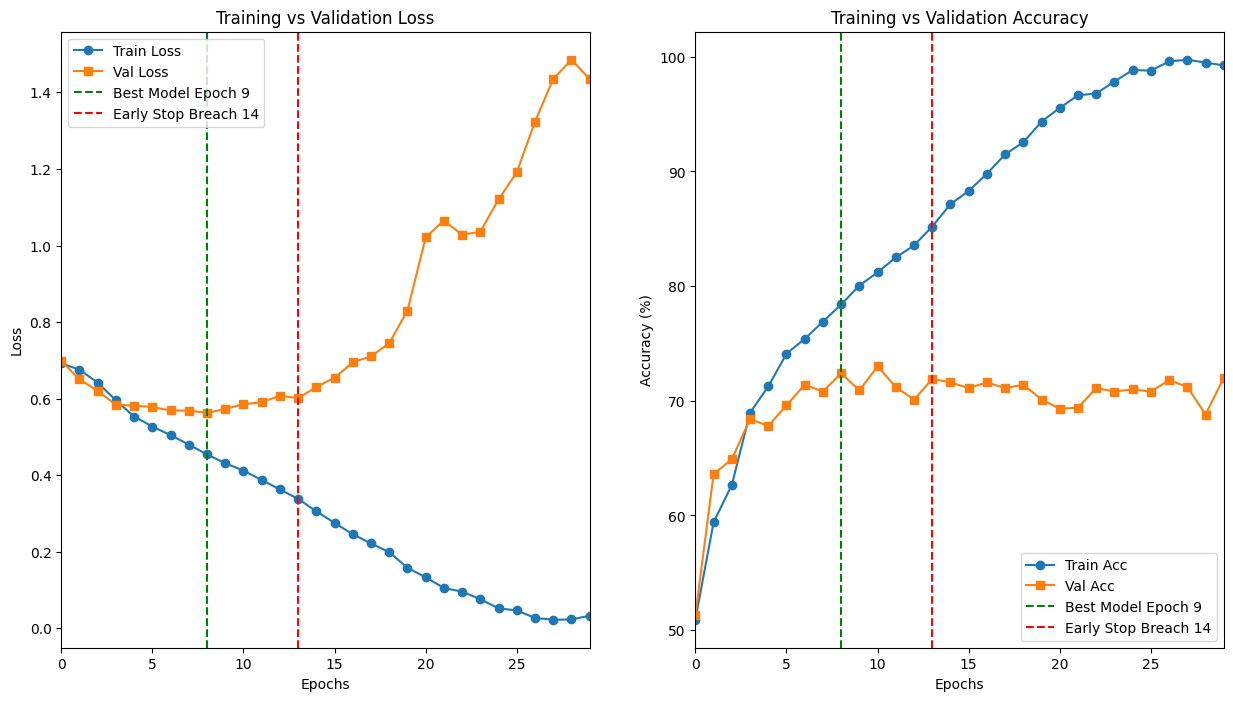

In [10]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(loss_list[:30], label="Train Loss", marker='o', linestyle='-')
plt.plot(val_loss_list[:30], label="Val Loss", marker='s', linestyle='-')
plt.axvline(best_epoch-1, color='g', linestyle='--', label=f'Best Model Epoch {best_epoch}') if best_epoch <= 30 else None
if early_stop_recorded and early_stop_epoch <= 30:
    plt.axvline(early_stop_epoch-1, color='r', linestyle='--', label=f'Early Stop Breach {early_stop_epoch}')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.xlim(0, 29)
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracy_list[:30], label="Train Acc", marker='o', linestyle='-')
plt.plot(val_acc_list[:30], label="Val Acc", marker='s', linestyle='-')
plt.axvline(best_epoch-1, color='g', linestyle='--', label=f'Best Model Epoch {best_epoch}') if best_epoch <= 30 else None
if early_stop_recorded and early_stop_epoch <= 30:
    plt.axvline(early_stop_epoch-1, color='r', linestyle='--', label=f'Early Stop Breach {early_stop_epoch}')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.xlim(0, 29)
plt.legend()

plt.show()
